In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import requests

from pandas import CategoricalDtype
from bs4 import BeautifulSoup
from datetime import date
from scipy import stats

import sys
import os

backend_path = os.path.abspath('../backend')
sys.path.append(backend_path)
from get_metrics import get_metrics



# Parcing data

In [2]:
# Парсинг ключевой ставки в df
URL = 'https://www.cbr.ru/hd_base/keyrate/?UniDbQuery.Posted=True&UniDbQuery.From=17.09.2013&UniDbQuery.To=' + date.today().strftime('%d.%m.%Y')

data = requests.get(URL).text

bs4 = BeautifulSoup(data, "html.parser")
table = bs4.find_all("table")

df = pd.read_html(str(table))[0]
df.iloc[:,1:] /= 100

In [3]:
# Преобразование столбца дата в формат datetime
df['Дата'] = pd.to_datetime(df['Дата'], dayfirst=True)

# Перенаименование столбцов
df.columns = ['date', 'key_rate']

In [4]:
# Общая информация о датафрейме
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2685 entries, 0 to 2684
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      2685 non-null   datetime64[ns]
 1   key_rate  2685 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 42.1 KB


In [5]:
# Основные описательные статистики для числовых признаков
df.iloc[:, 1:].describe()

,key_rate
count,2685.000000
mean,8.843855
std,3.295034
min,4.250000
25%,7.000000
50%,7.750000
75%,10.500000
max,20.000000


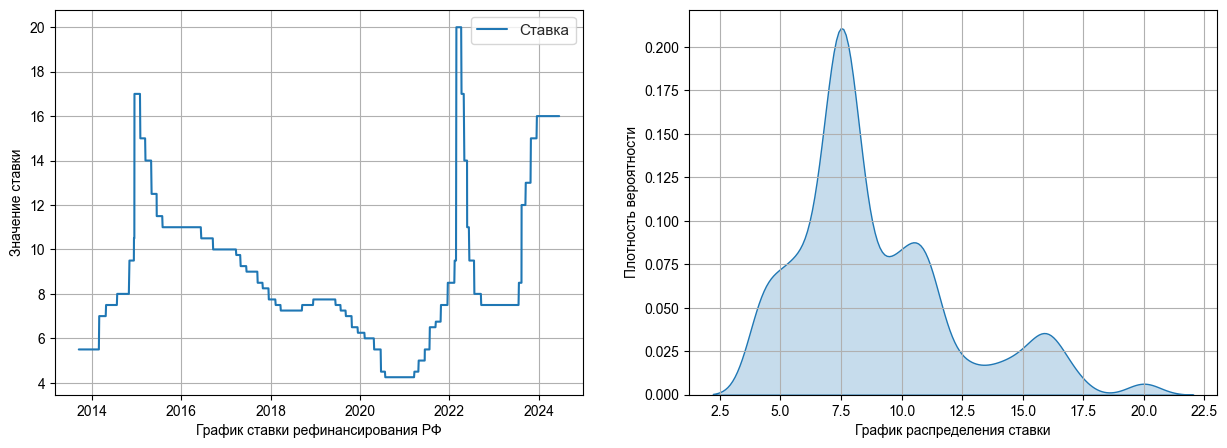

In [6]:
# Смотрим график курса ключевой ствки ЦБ РФ и график распределения
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

sns.set_theme(style="whitegrid", palette="Accent")

sns.lineplot(x='date', y='key_rate', data=df, label='Ставка', ax=ax[0])
ax[0].set_xlabel('График ставки рефинансирования РФ')
ax[0].set_ylabel('Значение ставки')
ax[0].legend(loc='best')
ax[0].grid(True)

sns.kdeplot(x=df['key_rate'], ax=ax[1], fill=True)
ax[1].grid(True)
ax[1].set_xlabel('График распределения ставки')
ax[1].set_ylabel('Плотность вероятности')
plt.show()

# EDA

In [7]:
# Проверка на нормальное или ненормальное распределение.
test_shapiro = stats.shapiro(df['key_rate'])

print(test_shapiro)

if test_shapiro.pvalue < 0.05:
    print('Распределение не нормальное')
else:
    print('Распределение нормальное')

ShapiroResult(statistic=0.9028582572937012, pvalue=2.575552666006177e-38)
Распределение не нормальное


In [8]:
def create_features(data, col_datetime):
    """Создание сезонов, дней недели, месяцев"""

    data = data.copy()
    data['weekday'] = data[col_datetime].dt.day_name().astype(cat_day)
    data['month'] = data[col_datetime].dt.month_name().astype(cat_month)
    data['year'] = data[col_datetime].dt.year
    data['quarter'] = data['date'].dt.quarter
    data['date_offset'] = (data[col_datetime].dt.month * 100 + data.date.dt.day - 320) % 1300
    data['season'] = data[col_datetime].dt.month.map({1: 'Winter', 2: 'Winter', 3: 'Spring', 4: 'Spring', 5: 'Spring', 6: 'Summer', 7: 'Summer', 8: 'Summer', 9: 'Autumn', 10: 'Autumn', 11: 'Autumn', 12: 'Winter'})
    
    return data

cat_day = CategoricalDtype(categories=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], ordered= True)
cat_month = CategoricalDtype(categories=['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December'], ordered= True)

df_features = create_features(data=df, col_datetime='date')

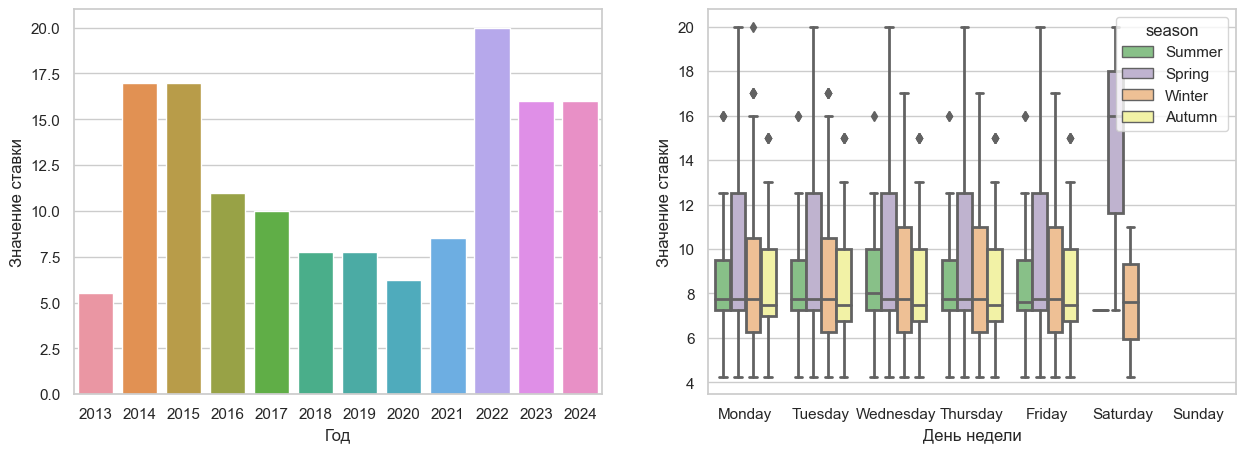

In [9]:
# Смотрим графики для анализа
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

year_group = pd.DataFrame(df_features.groupby('year')['key_rate'].max()).reset_index().sort_values('key_rate')

sns.barplot(data=year_group, x='year', y='key_rate', ax=ax[0])
ax[0].set_xlabel('Год')
ax[0].set_ylabel('Значение ставки')

sns.boxplot(data=df_features, x='weekday', y='key_rate', hue='season', ax=ax[1], linewidth=2)
ax[1].set_xlabel('День недели')
ax[1].set_ylabel('Значение ставки')

plt.show()



## Дропаем редкие субботние ставки

In [10]:
# Дропаем редкие субботние ключевые ставки
drop_trash = df_features[(df_features.weekday == 'Saturday')].index
df = df[~df.index.isin(drop_trash)]
df = df.reset_index(drop=True)

Смотрим график после дропа суббот

In [11]:
# Создаем df с признаками после дропа суббот
df_features = create_features(data=df, col_datetime='date')

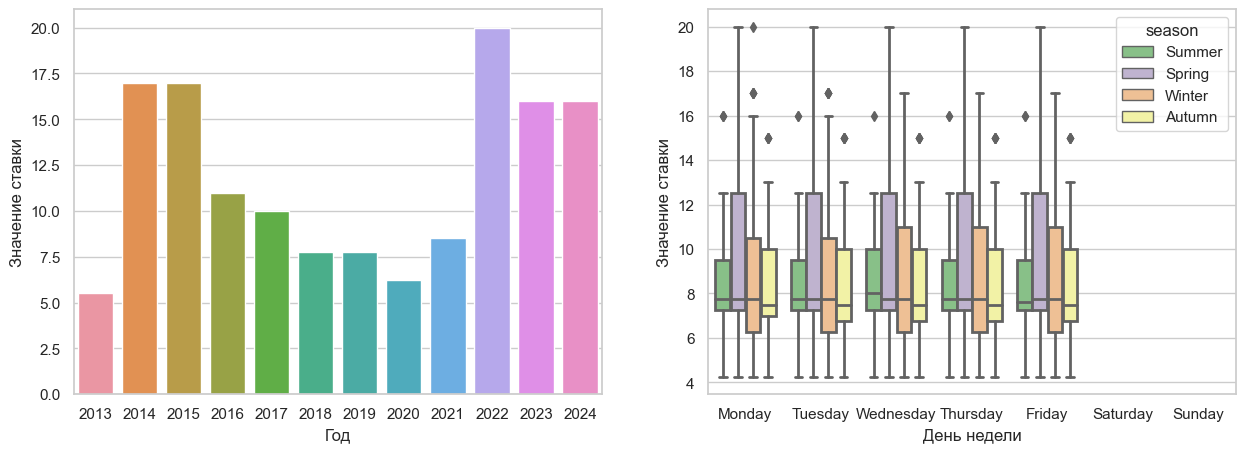

In [12]:
# Смотрим графики для анализа после дропа суббот
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

year_group = pd.DataFrame(df_features.groupby('year')['key_rate'].max()).reset_index().sort_values('key_rate')

sns.barplot(data=year_group, x='year', y='key_rate', ax=ax[0])
ax[0].set_xlabel('Год')
ax[0].set_ylabel('Значение ставки')

sns.boxplot(data=df_features, x='weekday', y='key_rate', hue='season', ax=ax[1], linewidth=2)
ax[1].set_xlabel('День недели')
ax[1].set_ylabel('Значение ставки')

plt.show()

## Поиск и удаление статистических выбросов

Далее будем вычислять и убирать статистические выбросы

## Определение выбросов при помощи IQR

In [13]:
# Определение последней даты, для заполнения графика интерполяцией
last_date = df['date'].max()

# Настройка фильтрации данных до последней даты
mask = df['date'] < last_date

# Вычисление межквартильного размаха (IQR)
q1 = df.loc[mask, 'key_rate'].quantile(0.25)
q3 = df.loc[mask, 'key_rate'].quantile(0.75)
iqr = q3 - q1

# Определение границ для выбросов
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

# Замена выбросов на NaN
df_filtered = df.copy()
df_filtered.loc[(df_filtered['key_rate'] < lower_bound) & mask, 'key_rate'] = np.nan
df_filtered.loc[(df_filtered['key_rate'] > upper_bound) & mask, 'key_rate'] = np.nan


In [14]:
# Считаем количество статистических выбросов
print(df_filtered['key_rate'].isna().sum())

193


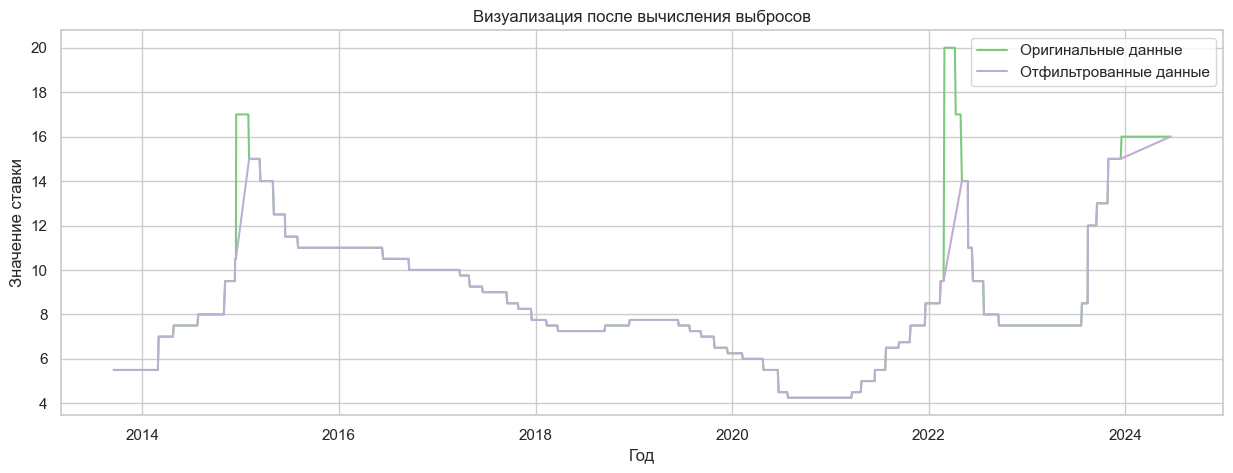

In [15]:
# Визуализация после вычисления выбросов
fig, ax = plt.subplots(figsize=(15, 5))

sns.set_theme(style="whitegrid", palette="Accent")

sns.lineplot(x='date', y='key_rate', data=df, label='Оригинальные данные', ax=ax)
sns.lineplot(x='date', y='key_rate', data=df_filtered, label='Отфильтрованные данные', ax=ax)

ax.set_xlabel('Год')
ax.set_ylabel('Значение ставки')
ax.set_title('Визуализация после вычисления выбросов')
ax.legend(loc='best')
ax.grid(True)

In [16]:
# Интерполируем пропущенные значения
df_filtered['key_rate'] = df_filtered['key_rate'].interpolate(method='nearest', order=3)

# Считаем количество статистических выбросов после интерполяции
print(df_filtered['key_rate'].isna().sum())

0


In [17]:
# Создаем df с признаками после замены статистических выбросов
df_features = create_features(data=df_filtered, col_datetime='date')

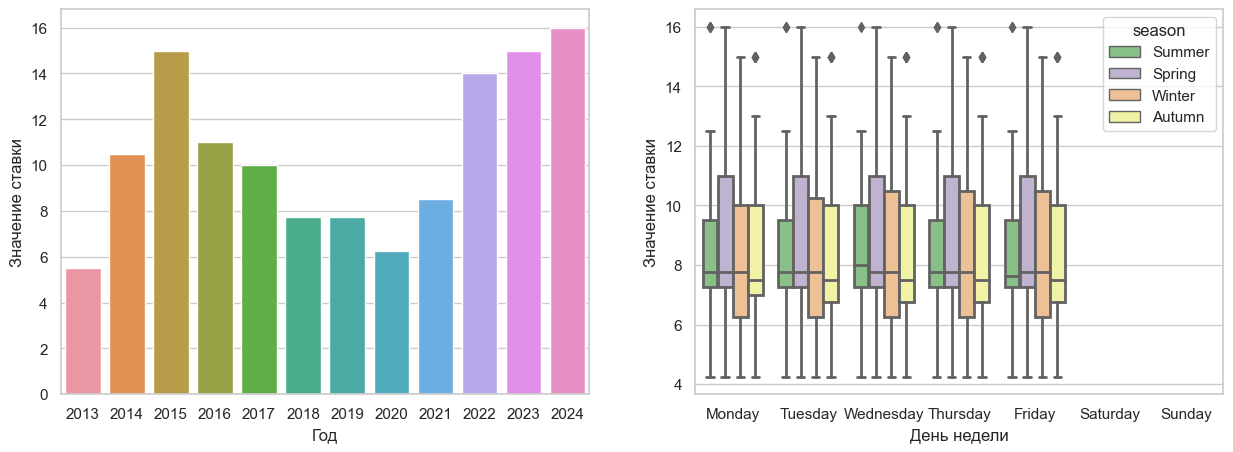

In [18]:
# Смотрим графики для анализа
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

year_group = pd.DataFrame(df_features.groupby('year')['key_rate'].max()).reset_index().sort_values('key_rate')

sns.barplot(data=year_group, x='year', y='key_rate', ax=ax[0])
ax[0].set_xlabel('Год')
ax[0].set_ylabel('Значение ставки')

sns.boxplot(data=df_features, x='weekday', y='key_rate', hue='season', ax=ax[1], linewidth=2)
ax[1].set_xlabel('День недели')
ax[1].set_ylabel('Значение ставки')

plt.show()

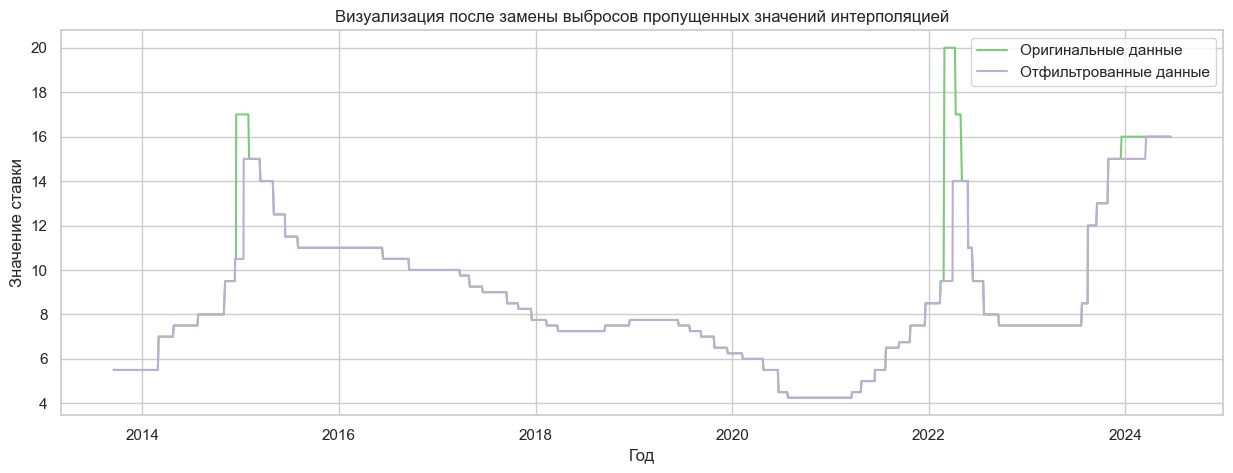

In [19]:
# Смотрим график после замены выбросов интерполяцией пропущенных значений
fig, ax = plt.subplots(figsize=(15, 5))

sns.set_theme(style="whitegrid", palette="Accent")

sns.lineplot(x='date', y='key_rate', data=df, label='Оригинальные данные', ax=ax)
sns.lineplot(x='date', y='key_rate', data=df_filtered, label='Отфильтрованные данные', ax=ax)

ax.set_xlabel('Год')
ax.set_ylabel('Значение ставки')
ax.set_title('Визуализация после замены выбросов пропущенных значений интерполяцией')
ax.legend(loc='best')
ax.grid(True)

In [20]:
# сохранение отфилтрованных данных в df
df = df_filtered

In [21]:
# Перенаименование названия колонок для prophet
df.columns = ['ds', 'y']

# Период, который надо отрезать и предсказать (проверка модели)
pred_days = int(df.shape[0]*0.1)


In [22]:
# Сортируем данные по возрастанию для корректного отображения разделения графика
df = df.sort_values('ds')
df = df.reset_index(drop=True)

In [23]:
# Разделение данных на train, test
df_train = df[:-pred_days]
df_test = df[-pred_days:]


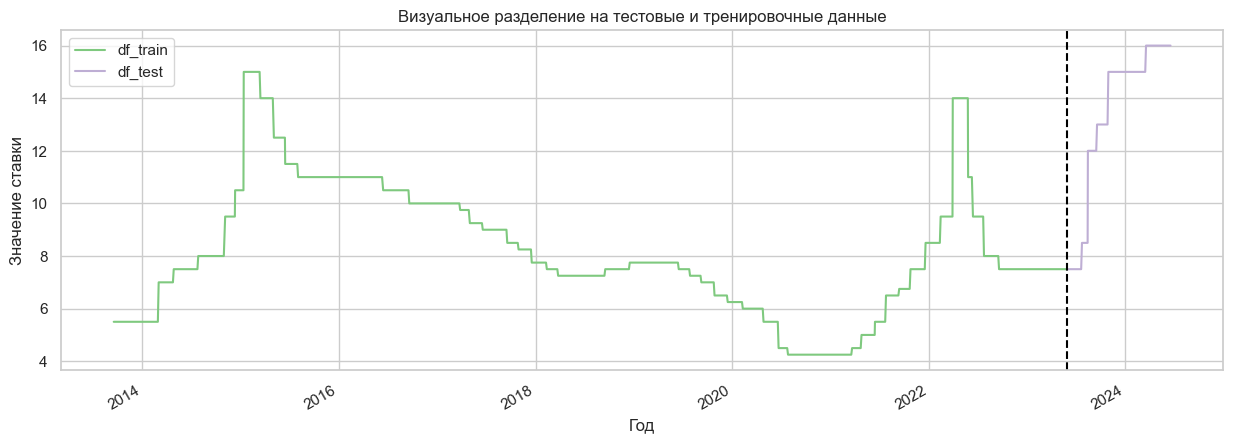

In [24]:
# Отображаем график с разделением train, test для наглядности
fig, ax = plt.subplots(figsize = (10, 5))

fig.set_figheight(5)
fig.set_figwidth(15)
df_train.set_index('ds').plot(ax=ax, label= 'train', title='Визуальное разделение на тестовые и тренировочные данные')
df_test.set_index('ds').plot(ax=ax, label='test')
ax.axvline(df_train['ds'][-1:].values, ls='--', color='black')
ax.legend(['df_train', 'df_test'])
ax.set_ylabel('Значение ставки')
ax.set_xlabel('Год')
plt.show()

In [25]:
# Сохранение DataFrame df в файл data/df.csv
df.to_csv('../data/df.csv', index=False)

# Сохранение DataFrame df_train в файл data/df_train.csv
df_train.to_csv('../data/df_train.csv', index=False)

# Сохранение DataFrame df_test в файл data/df_test.csv
df_test.to_csv('../data/df_test.csv', index=False)
